In [ ]:
!nvidia-smi

Sat Jun  3 09:22:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles')
!pwd

/content
/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles


In [ ]:
!pip install transformers
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 23.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import gc

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, ConfusionMatrix, AUROC, Precision, Recall, F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
train_df = pd.read_csv("Datasets/Splits/Train/final_labels_SG2_label_bias_train.csv")
test_df = pd.read_csv("Datasets/Splits/Test/final_labels_SG2_label_bias_test.csv")

In [ ]:
(train_df.shape, test_df.shape)

((2571, 2), (1102, 2))

In [ ]:
(train_df.head(), test_df.head())

(                                                text  bias
 0  Letters from GOP members of Congress and natio...     1
 1  Activist Dorian Wilde said anti-LGBT statement...     0
 2  U.S. President Donald Trump retweeted a video ...     1
 3  Everything in the progressive agenda is aimed ...     1
 4  Even pro-life leaders have expressed their app...     0,
                                                 text  bias
 0  Protests erupted in Louisville and several oth...     0
 1  The legislation is the most sweeping college a...     0
 2  Left-wing Christians declare that the real way...     1
 3  Perhaps the pushback from the Pentagon will in...     1
 4  Trump's latest conspiracy theory seems to echo...     0)

In [ ]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row['text'],
    truncation = True,
    max_length = 512
  ))
  token_counts.append(token_count)

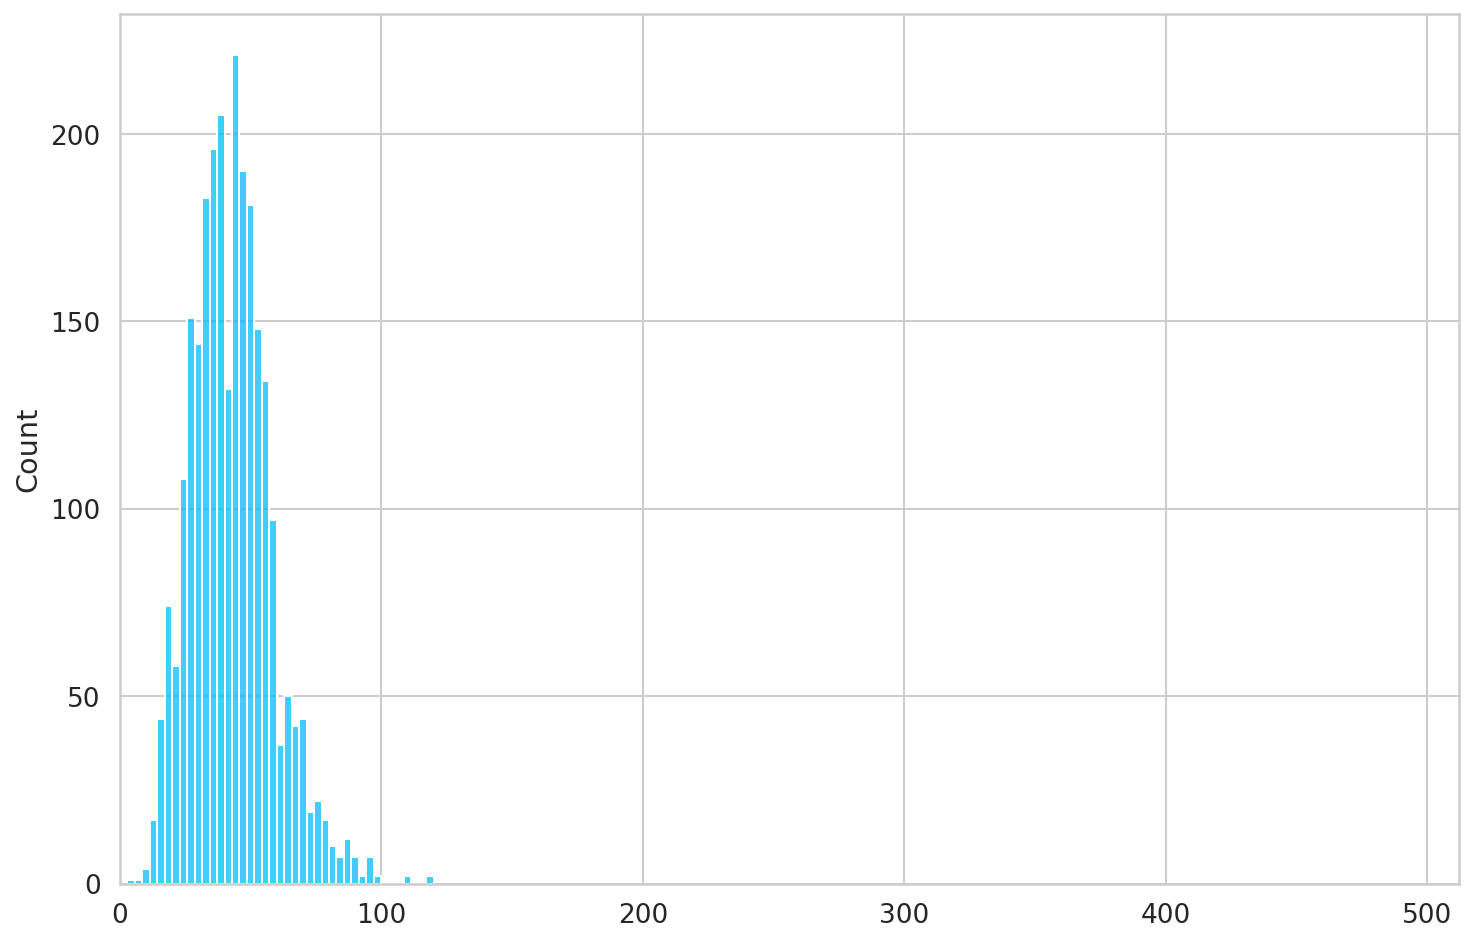

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [ ]:
max = 0
maxLst = []

for i in token_counts:
  if i > max:
    max = i
    maxLst.append(i)

maxLst
#max_length = 150

[57, 59, 80, 120]

In [ ]:
TEXT = ['text']
CLASSES = ['bias']
TARGET = ['bias']
TASK = "binary"

In [ ]:
MAX_TOKEN_COUNT = 150

In [ ]:
N_EPOCHS = 3
BATCH_SIZE = 16

In [ ]:
class DTset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 512
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row[TEXT].astype(str).values.tolist()
    classification = data_row[TARGET]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      is_split_into_words = True,
      return_attention_mask=True,
      return_tensors='pt'
    )

    return dict(
      text = text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      classification = torch.FloatTensor(classification)
    )

In [ ]:
class DTModule(pl.LightningDataModule):

  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size = 16, max_token_len = 512):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = DTset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.val_dataset = DTset(
      self.val_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = DTset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
class BertBasedClassifier(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.sigmoid = nn.Sigmoid()
    self.crossEntropy = nn.BCELoss()
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps

  def forward(self, input_ids, attention_mask, classification=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.out(output.pooler_output)
    output = self.sigmoid(output)
    loss = 0
    if classification is not None:
        loss = self.crossEntropy(output, classification)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    classification = batch["classification"]
    loss, outputs = self(input_ids, attention_mask, classification)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    gc.collect()
    return {"loss": loss, "predictions": outputs, "classification": classification}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    classification = batch["classification"]
    loss, outputs = self(input_ids, attention_mask, classification)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    gc.collect()
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    classification = batch["classification"]
    loss, outputs = self(input_ids, attention_mask, classification)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    gc.collect()
    return loss

  def train_epoch_end(self, outputs):
    predictions = []
    target = []
    for output in outputs:
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
      for out_class in output["classification"].detach().cpu():
        target.append(out_class)
    predictions = torch.stack(predictions)
    target = torch.stack(target).int()
    predictions = torch.from_numpy(np.array(predictions))
    target = torch.from_numpy(np.array(target))
    binary_auroc = AUROC(task=TASK)
    auroc = binary_auroc(predictions, target)
    self.logger.experiment.add_scalar(f"binary_auroc/Train", auroc, self.current_epoch)
    predictions.clear()
    target.clear()
    gc.collect()

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

# K-Fold Model Training + K-Fold Cross-Validation

In [ ]:
def runKFold(dt_train, f = 5):
  gc.enable()

  X = dt_train[TEXT]
  y = dt_train[TARGET]

  k = 1

  skfold = StratifiedKFold(n_splits = f, shuffle=True, random_state=42)

  val_loss = []
  val_acc = []
  val_prec = []
  val_rec = []
  val_f1 = []
  val_auroc = []

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  for train_index, val_index in skfold.split(X,y):
    print('### Start fold {}'.format(k))

    train_dt = dt_train.iloc[train_index]
    val_dt = dt_train.iloc[val_index]

    train_dt.to_csv(f'Datasets/Splits/Train/final_labels_SG2_label_bias_train_KFold{k}.csv', index = False)
    val_dt.to_csv(f'Datasets/Splits/Validation/final_labels_SG2_label_bias_val_KFold{k}.csv', index = False)

    data_module = DTModule(
      train_dt,
      val_dt,
      None,
      tokenizer,
      batch_size = BATCH_SIZE,
      max_token_len = MAX_TOKEN_COUNT
    )

    steps_per_epoch=len(train_dt) // BATCH_SIZE
    total_training_steps = steps_per_epoch * N_EPOCHS
    warmup_steps = total_training_steps // 5

    model = BertBasedClassifier(
      n_classes= len(CLASSES),
      n_warmup_steps=warmup_steps,
      n_training_steps=total_training_steps
    )

    logger = TensorBoardLogger("Lightning_logs", name="Lexicon-of-Sentences-BABESG2-Biased-Statements-logs")

    early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 2)

    checkpoint_callback = ModelCheckpoint(
      dirpath="Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements",
      filename=f'Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold{k}-Best-Checkpoint',
      save_top_k=1,
      verbose=True,
      monitor="val_loss",
      mode="min"
    )

    trainer = pl.Trainer(
      logger=logger,
      callbacks=[early_stopping_callback, checkpoint_callback],
      max_epochs=N_EPOCHS,
      accelerator="gpu"
    )

    trainer.fit(model, data_module)
    del model
    gc.collect()

    model = BertBasedClassifier.load_from_checkpoint(
      trainer.checkpoint_callback.best_model_path,
      n_classes=len(CLASSES)
    )
    model.eval()
    model.freeze()

    loss = trainer.validate(model, data_module)
    loss = loss[0].get("val_loss")

    model = model.to(device)

    val_dataset = DTset(
      val_dt,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    predictions = []
    target = []

    for item in tqdm(val_dataset):
      _, prediction = model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
      )
      predictions.append(prediction.flatten())
      target.append(item["classification"].int())

    predictions = torch.stack(predictions).detach().cpu()
    target = torch.stack(target).detach().cpu()

    accuracy = Accuracy(task = TASK, threshold=0.5)
    precision = Precision(task = TASK, threshold=0.5)
    recall = Recall(task = TASK, threshold=0.5)
    f1 = F1Score(task = TASK, threshold=0.5)
    auroc = AUROC(task = TASK)

    val_loss.append(loss)
    val_acc.append(accuracy(predictions, target).item())
    val_prec.append(precision(predictions, target).item())
    val_rec.append(recall(predictions, target).item())
    val_f1.append(f1(predictions, target).item())
    val_auroc.append(auroc(predictions, target).item())

    del trainer
    del model

    del train_dt
    del val_dt
    del data_module
    del val_dataset

    del steps_per_epoch
    del total_training_steps
    del warmup_steps

    del logger
    del early_stopping_callback
    del checkpoint_callback

    del predictions
    del target

    del loss
    del accuracy
    del precision
    del recall
    del f1
    del auroc

    torch.cuda.empty_cache()
    gc.collect()

    k += 1

  return val_loss, val_acc, val_prec, val_rec, val_f1, val_auroc

In [ ]:
val_loss, val_acc, val_prec, val_rec, val_f1, val_auroc = runKFold(train_df, 5)

### Start fold 1


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 T

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 129: 'val_loss' reached 0.52260 (best 0.52260), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold1-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 258: 'val_loss' reached 0.45856 (best 0.45856), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold1-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 387: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.45856359601020813    │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/515 [00:00<?, ?it/s]

### Start fold 2


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 T

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 129: 'val_loss' reached 0.53032 (best 0.53032), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold2-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 258: 'val_loss' reached 0.49453 (best 0.49453), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold2-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 387: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.49452802538871765    │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/514 [00:00<?, ?it/s]

### Start fold 3


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 T

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 129: 'val_loss' reached 0.51718 (best 0.51718), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold3-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 258: 'val_loss' reached 0.49108 (best 0.49108), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold3-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 387: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.4910787343978882     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/514 [00:00<?, ?it/s]

### Start fold 4


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 T

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 129: 'val_loss' reached 0.49953 (best 0.49953), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold4-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 258: 'val_loss' reached 0.45243 (best 0.45243), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold4-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 387: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.4524315297603607     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/514 [00:00<?, ?it/s]

### Start fold 5


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 T

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 129: 'val_loss' reached 0.54294 (best 0.54294), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold5-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 258: 'val_loss' reached 0.49945 (best 0.49945), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-KFold5-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 387: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.4994513988494873     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/514 [00:00<?, ?it/s]

In [ ]:
val_loss

[0.45856359601020813,
 0.49452802538871765,
 0.4910787343978882,
 0.4524315297603607,
 0.4994513988494873]

In [ ]:
val_acc

[0.7961165308952332,
 0.7509727478027344,
 0.7704280018806458,
 0.7840467095375061,
 0.7470816969871521]

In [ ]:
val_prec

[0.7936508059501648,
 0.7118644118309021,
 0.7463235259056091,
 0.7786561250686646,
 0.7242646813392639]

In [ ]:
val_rec

[0.790513813495636,
 0.8300395011901855,
 0.8055555820465088,
 0.7817460298538208,
 0.7817460298538208]

In [ ]:
val_f1

[0.7920792102813721,
 0.7664233446121216,
 0.7748091816902161,
 0.7801980376243591,
 0.7519084215164185]

In [ ]:
val_auroc

[0.872974693775177,
 0.8557236194610596,
 0.8460862040519714,
 0.8660941123962402,
 0.8503726720809937]

In [ ]:
loss_cv_mean = np.mean(val_loss)
acc_cv_mean = np.mean(val_acc)
prec_cv_mean = np.mean(val_prec)
rec_cv_mean = np.mean(val_rec)
f1_cv_mean = np.mean(val_f1)
auroc_cv_mean = np.mean(val_auroc)

print('5-Fold CV Mean')
print('5-Fold CV Loss: {}'.format(loss_cv_mean))
print('5-Fold CV Accuracy: {}'.format(acc_cv_mean))
print('5-Fold CV Precision: {}'.format(prec_cv_mean))
print('5-Fold CV Recall: {}'.format(rec_cv_mean))
print('5-Fold CV F1 Score: {}'.format(f1_cv_mean))
print('5-Fold CV AUROC: {}'.format(auroc_cv_mean))

5-Fold CV Mean
5-Fold CV Loss: 0.4792106568813324
5-Fold CV Accuracy: 0.7697291374206543
5-Fold CV Precision: 0.7509519100189209
5-Fold CV Recall: 0.7979201912879944
5-Fold CV F1 Score: 0.7730836391448974
5-Fold CV AUROC: 0.8582502603530884


In [ ]:
loss_cv_std = np.std(val_loss)
acc_cv_std = np.std(val_acc)
prec_cv_std = np.std(val_prec)
rec_cv_std = np.std(val_rec)
f1_cv_std = np.std(val_f1)
auroc_cv_std = np.std(val_auroc)

print('5-Fold CV Standard Deviation')
print('5-Fold CV Loss: {}'.format(loss_cv_std))
print('5-Fold CV Accuracy: {}'.format(acc_cv_std))
print('5-Fold CV Precision: {}'.format(prec_cv_std))
print('5-Fold CV Recall: {}'.format(rec_cv_std))
print('5-Fold CV F1 Score: {}'.format(f1_cv_std))
print('5-Fold CV AUROC: {}'.format(auroc_cv_std))

5-Fold CV Standard Deviation
5-Fold CV Loss: 0.01963967132784311
5-Fold CV Accuracy: 0.018796193906880098
5-Fold CV Precision: 0.031151827792181553
5-Fold CV Recall: 0.01826477861255788
5-Fold CV F1 Score: 0.013469768004519682
5-Fold CV AUROC: 0.009947256218224575


In [ ]:
cv_mean = ["cv mean", loss_cv_mean, acc_cv_mean, prec_cv_mean, rec_cv_mean, f1_cv_mean, auroc_cv_mean]
cv_std = ["cv std", loss_cv_std, acc_cv_std, prec_cv_std, rec_cv_std, f1_cv_std, auroc_cv_std]

In [ ]:
five_k_cv_result_data = {'k': [1, 2, 3, 4, 5],
                          'val_loss': val_loss,
                          'val_acc': val_acc,
                          'val_prec': val_prec,
                          'val_rec': val_rec,
                          'val_f1': val_f1,
                          'val_auroc': val_auroc}

five_k_cv_result_df = pd.DataFrame(five_k_cv_result_data)

In [ ]:
five_k_cv_result_df = five_k_cv_result_df.append(dict(zip(five_k_cv_result_df.columns, cv_mean)), ignore_index=True)
five_k_cv_result_df = five_k_cv_result_df.append(dict(zip(five_k_cv_result_df.columns, cv_std)), ignore_index=True)

<ipython-input-27-f8ca0e644d46>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  five_k_cv_result_df = five_k_cv_result_df.append(dict(zip(five_k_cv_result_df.columns, cv_mean)), ignore_index=True)
<ipython-input-27-f8ca0e644d46>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  five_k_cv_result_df = five_k_cv_result_df.append(dict(zip(five_k_cv_result_df.columns, cv_std)), ignore_index=True)


In [ ]:
five_k_cv_result_df

,k,val_loss,val_acc,val_prec,val_rec,val_f1,val_auroc
0,1,0.458564,0.796117,0.793651,0.790514,0.792079,0.872975
1,2,0.494528,0.750973,0.711864,0.830040,0.766423,0.855724
2,3,0.491079,0.770428,0.746324,0.805556,0.774809,0.846086
3,4,0.452432,0.784047,0.778656,0.781746,0.780198,0.866094
4,5,0.499451,0.747082,0.724265,0.781746,0.751908,0.850373
5,cv mean,0.479211,0.769729,0.750952,0.797920,0.773084,0.858250
6,cv std,0.019640,0.018796,0.031152,0.018265,0.013470,0.009947


In [ ]:
five_k_cv_result_df.to_csv('CV_validation/Bias_statement_anthology_BABESG2.csv', index = False)

# Final Model Training + Train/Test Evaluation

In [ ]:
train_dt = pd.read_csv("Datasets/Splits/Train/final_labels_SG2_label_bias_train.csv")
test_dt = pd.read_csv("Datasets/Splits/Test/final_labels_SG2_label_bias_test.csv")

In [ ]:
(train_dt.shape, test_dt.shape)

((2571, 2), (1102, 2))

In [ ]:
data_module = DTModule(
  train_dt,
  test_dt,
  test_dt,
  tokenizer,
  batch_size = BATCH_SIZE,
  max_token_len = MAX_TOKEN_COUNT
)

In [ ]:
steps_per_epoch=len(train_dt) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(96, 480)

In [ ]:
model = BertBasedClassifier(
  n_classes= len(CLASSES),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

BertBasedClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
logger = TensorBoardLogger("Lightning_logs", name="Lexicon-of-Sentences-BABESG2-Biased-Statements-logs")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 2)

checkpoint_callback = ModelCheckpoint(
  dirpath="Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements",
  filename="Lexicon-of-Sentences-BABESG2-Biased-Statements-Best-Checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  accelerator="gpu"
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type      | Params
-------------------------------------------
0 | bert         | BertModel | 108 M 
1 | out          | Linear    | 769   
2 | sigmoid      | Sigmoid   | 0     
3 | crossEntropy | BCELoss   | 0     
-------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.244   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 161: 'val_loss' reached 0.47054 (best 0.47054), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 322: 'val_loss' reached 0.44114 (best 0.44114), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 483: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
del model
gc.collect()

0

In [ ]:
trained_model = BertBasedClassifier.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(CLASSES)
)
trained_model.eval()
trained_model.freeze()

"""
Load from DIR
trained_model = Tagger.load_from_checkpoint(
  "Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-Best-Checkpoint.ckpt",
  n_classes=len(LABELS)
)
trained_model.eval()
trained_model.freeze()
"""

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'\nLoad from DIR\ntrained_model = Tagger.load_from_checkpoint(\n  "Best_model/Lexicon_of_Sentences_BABESG2_Biased_Statements/Lexicon-of-Sentences-BABESG2-Biased-Statements-Best-Checkpoint.ckpt",\n  n_classes=len(LABELS)\n)\ntrained_model.eval()\ntrained_model.freeze()\n'

In [ ]:
trainer.test(trained_model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4411415755748749     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4411415755748749}]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = DTset(
  test_dt,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
target = []

for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  target.append(item["classification"].int())

predictions = torch.stack(predictions).detach().cpu()
target = torch.stack(target).detach().cpu()

  0%|          | 0/1102 [00:00<?, ?it/s]

In [ ]:
predictions

tensor([[0.0453],
        [0.1646],
        [0.9507],
        ...,
        [0.0862],
        [0.2466],
        [0.9649]])

In [ ]:
target

tensor([[0],
        [0],
        [1],
        ...,
        [0],
        [1],
        [1]], dtype=torch.int32)

In [ ]:
confusionMatrix = ConfusionMatrix(task = TASK, threshold = 0.5)
confusionMatrix(predictions, target)

tensor([[412, 142],
        [ 81, 467]])

In [ ]:
accuracy = Accuracy(task = TASK, threshold = 0.5)
print("Accuracy:", accuracy(predictions, target).item())

Accuracy: 0.7976406812667847


In [ ]:
precision = Precision(task = TASK, threshold = 0.5)
recall = Recall(task = TASK, threshold = 0.5)
f1Macro = F1Score(task = TASK, threshold = 0.5)
print("Percision:", precision(predictions, target).item(), "\nRecall:", recall(predictions, target).item(), "\nF1 Score:", f1Macro(predictions, target).item())

Percision: 0.7668308615684509 
Recall: 0.8521897792816162 
F1 Score: 0.8072601556777954


In [ ]:
auroc = AUROC(task = TASK)
print("AUROC:", auroc(predictions, target).item())

AUROC: 0.8843217492103577


In [ ]:
test_dt['bias'].value_counts()

0    554
1    548
Name: bias, dtype: int64